# Q-learning for Dynamic Activation of Base Station Resources in Wireless Networks 

This work is inspired by the article "Reinforcement learning approach to dynamic activation of base station resources in wireless networks." by Peng-Yong Kong and Dorin Panaitopol on Personal Indoor and Mobile Radio Communications (PIMRC), 2013 IEEE 24th International Symposium on. IEEE, 2013. [1] 

## Introduction

We can consider a system in which a Base Station (BS) has several resources, these resources can be activated or deactivated by the system accordinly to some scheme or model. We propose a Q-learning algorithm to execute this process. this Q-learning model takes into account the number of users connected to the BS, the resources currently activated in the BS and it seeks to search a better energy efficiency while trying to avoid user blocking. 

A blocking happens when the number of users surpasses the maximum number of users tolerated by the BS, which is a function of the number of resources active at a given momment.

## Definitions
* Discrete Model
* Base Station with multiple resources
* Let m[n] be the number of active resources at a time slot n.
* So the Energy Consumption can be defined as P<sup>bs</sup> = P<sup>bs</sup> + m[n] P<sup>r</sup>

## 1. Imports and Useful Functions

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

### 1. Function for Calculating the Reward for our Reinforcement Learning Algorithm

In [2]:
def action_reward(u,m,a,M=30,U=50,P=-1000):
    if u<=(m+a)*U:
        R=M-m-a
    else:
        R=P
    return R

### 2. Function to pick the state
Pick the state based on the number of active users *u* and active resources *m*

In [3]:
def pick_state(u,m,U=50,N=25):
    return m*(M*(U//N)+1)+math.ceil(u/N) 

### 3. Function to Model the Network Traffic
Returns a random integer (number of active users). The mean this random integer, *beta*, is a time (*n*) dependent function.    

In [4]:
def lambdan(n,peak):
    beta=(20 + (8*math.sin(2*math.pi*(960+n)/1440)))*peak/29
    b=math.ceil(beta)
    return np.random.randint(low=b-10,high=b+10+1)

### 4. Function to Initiate de Q-Factors
We don't initiate the Q-Factors as 0 to speed up the training. Rather, we start all the values that we see as a blocking condition do a value *P* =-1000, all the others Q-Factors are set to 0. 

In [5]:
def initiate_qtable(length,M=30,U=50,N=25,P=-1000):
    Q=np.zeros([length, M+1])
    for ii in range(0,M+1):
        for jj in range(0,M*U+1):
            state=pick_state(u=jj,m=ii,N=N,U=U)
            for col in range(0,M+1):
                a=col-ii
                if ((jj>(ii+a)*U) and (a<=0)):
                    Q[state][col]=P
    return Q

### 5. ε-Greedy Approach Function  
In this Function we do the ε-greedy approach for a given state (u,m). 
We did a change from the original way, the random choice (exploration) is done between the actions that don't lead to a blocking. 

In [6]:
def epsilon_greedy(Q,State0,m0,epsilon=0.05,M=30):
    if np.random.rand()<epsilon:
        if len(np.where(Q[State0]>-1000))>0: #checks if there is at least one state that doesn't lead to block
            a=np.random.choice(np.where(Q[State0]>-1000)[0])-m0 #prevents moving to a blocking state
        else:
            a=np.random.randint(low=0,high=M+1)-m0
    else: 
        a=Q[state0].argmax()-m0
    return a

This is the normal ε-greedy approach:

In [7]:
def epsilon_greedy2(Q,State0,m0,epsilon=0.05,M=30):
    if np.random.rand()<epsilon:
        a=np.random.randint(low=0,high=M+1)-m0
    else: 
        a=Q[state0].argmax()-m0
    return a

### 6. Function to Test Our Agent
We use an fixed test (*vtU*) to evaluate our Q-table and return the accumulated blocking rate and energy saved. 

In [8]:
def teste_qtable(Q,vtU,alpha=0.5,gamma=0.3,M=30,U=50,N=25,P=-1000):
    EnS=0
    pblock=0
    m0=6
    u0=vtU[0]
    for u in vtU:
        state0=pick_state(u=u0,m=m0,N=N,U=U)
        a=Q[state0].argmax()-m0
        m1=m0+a
        u0=u
        state1=pick_state(u=u0,m=m1,N=N,U=U)
        r=action_reward(u=u0,m=m0,a=a,M=30,U=50,P=-1000)
        if r==P:
            pblock=pblock+1
        Q[state0][a+m0]=(1-alpha)*Q[state0][a+m0] + alpha*(r + gamma*(Q[state1].max()))
        m0=m1
        EnS=EnS+(M-m0)
    return pblock,EnS

In [9]:
sns.set_style(style='darkgrid')

## 2. Evaluating the Perfomance based on Alpha and Gamma
In this section we aim to compare the performance changing the learning rates and discount rates, and see how the influentiate the overall performance.

### 1. System parameters 

In [10]:
Pcnt=100 #fixed power
Pr=30 #Power per resource
M=30 #max number of resources
U=50 #max number of users by each resource
N=25 #quantization of users
peak=900 #peak of traffic
P=-1000 #penalization
epsilon=0.05 #epsilon fo e-greedy
gamma=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] #discount rates
alpha=[0.3, 0.5, 0.7] #learning rates
maxEps=24*60*30 #Time for simulation: 30 days
dMC=50 #number of monte carlo simulations

### 2. Q learning Parameters:

In [11]:
un=30
mn=5
lenStateSpace=(M+1)*(M*(U//N)+1)

### 3. Online Q learning

In [12]:
vtBlock=np.zeros([len(alpha),len(gamma)])
vtEnS=np.zeros([len(alpha),len(gamma)])
for mc in range(dMC):
    for rate in range(0,len(alpha)):
        alphan=alpha[rate]
        for discount in range(0,len(gamma)):
            gamman=gamma[discount]
            Q=initiate_qtable(length=lenStateSpace,M=M,U=U,N=N,P=P)
            m0=6
            pblock=0
            EnS=0
            u0=lambdan(0,peak)
            for epoch in range(0,maxEps):
                state0=pick_state(u=u0,m=m0,N=N,U=U)
                a = epsilon_greedy(Q,state0,m0,epsilon,M)
                m1=m0+a
                u0=lambdan(epoch,peak)
                state1=pick_state(u=u0,m=m1,N=N,U=U)
                r=action_reward(u=u0,m=m0,a=a,M=30,U=50,P=-1000)
                if r==P:
                    pblock=pblock+1
                Q[state0][a+m0]=(1-alphan)*Q[state0][a+m0] + alphan*(r + gamman*(Q[state1].max()))
                m0=m1
                EnS=EnS+(M-m0)
            vtBlock[rate][discount]=vtBlock[rate][discount]+pblock
            vtEnS[rate][discount]=vtEnS[rate][discount]+EnS

Calculating the blocking rate and the Pct of the energy saved:

In [13]:
vtBlock=(vtBlock/maxEps)/dMC
vtEnS=((vtEnS/maxEps)*100/M)/dMC

### 4. Visualizations

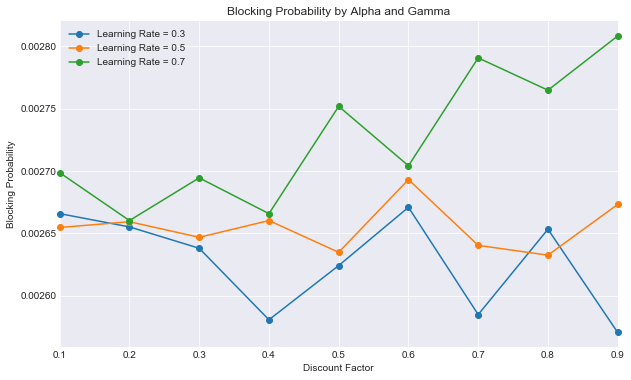

In [14]:
dfBlock=pd.DataFrame(vtBlock.T,index=gamma,columns=alpha)
dfBlock.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Blocking Probability')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Blocking Probability by Alpha and Gamma')
plt.rc('font',size=13)
plt.show()

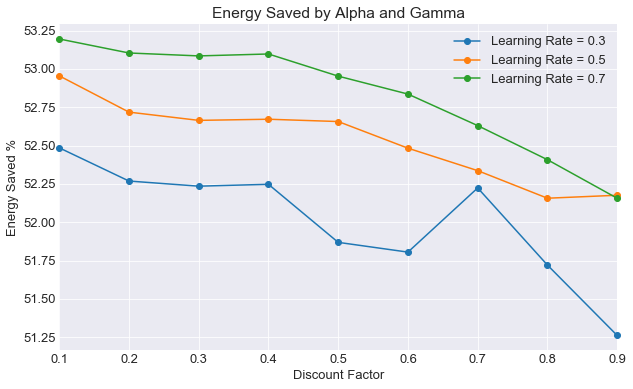

In [15]:
dfEnS=pd.DataFrame((vtEnS).T,index=gamma,columns=alpha)
dfEnS.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Energy Saved %')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Energy Saved by Alpha and Gamma')
plt.rc('font',size=13)
plt.show()

## 3. Evaluating the Agent using a Test

* In this section we use a fixed test day to compare how our agent is performing, based on the test, as it learns. 
* After a full day of training we take the Q-Table and use it to see the performance on our test set.
* When testing we don't use a e-greedy approach

### 1. Creating Our Test Day and Visualizing It

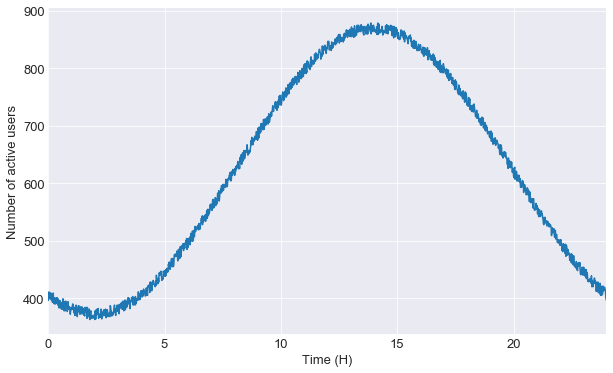

In [16]:
vtU=[]
for ii in range(0,60*24):
    vtU.append(lambdan(ii,peak))
seU=pd.Series(vtU)
seU.index=seU.index/(60)
seU.plot(figsize=(10,6))
plt.xlabel('Time (H)')
plt.ylabel('Number of active users')
plt.show()

### 2. Simulation
* We make a full month simulation
* After each complete day we execute a teste to see how our agent performs on the test set
* That way we can visualize the evolution of our agent is the time goes on.

System Parameters for this simulation are defined below:

In [17]:
alpha=0.5
gamma=0.3
epsilon=0.2

Simulating and testing during a full month

In [18]:
Q=initiate_qtable(length=lenStateSpace,M=M,U=U,N=N,P=P)
m0=6
vtBlock=[]
vtEnS=[]
contador=0
u0=lambdan(0,peak)
for epoch in range(0,24*60*30):
    contador=contador+1
    state0=pick_state(u=u0,m=m0,N=N,U=U)
    a=epsilon_greedy(Q,state0,m0,epsilon,M)
    m1=m0+a
    u0=lambdan(epoch,peak)
    state1=pick_state(u=u0,m=m1,N=N,U=U)
    r=action_reward(u=u0,m=m0,a=a,M=30,U=50,P=-1000)
    Q[state0][a+m0]=(1-alpha)*Q[state0][a+m0] + alpha*(r + gamma*(Q[state1].max()))
    m0=m1
    ######teste#####
    if contador==24*60:
        pblock,EnS=teste_qtable(Q=Q,vtU=vtU,alpha=0.5,gamma=0.3,M=30,U=50,N=25,P=-1000)
        vtBlock.append(pblock/(60*24))
        vtEnS.append(EnS/(60*24)*100/M)
        contador=0

### 3. Visualizing the Perfomance

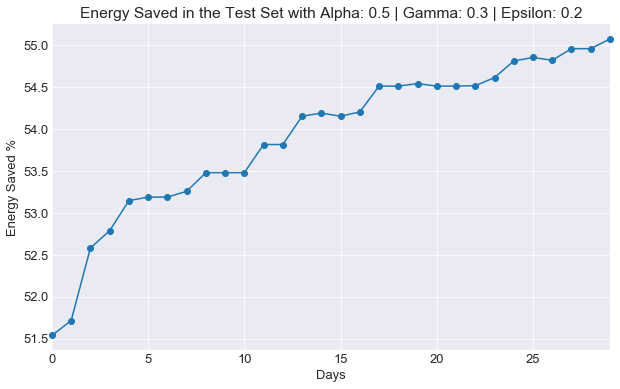

In [19]:
SEnS=pd.Series(vtEnS)
SEnS.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Energy Saved %')
plt.xlabel('Days')
plt.title('Energy Saved in the Test Set with Alpha: ' + str(alpha) + ' | Gamma: ' + str(gamma)+  ' | Epsilon: ' + str(epsilon))
plt.rc('font',size=13)
plt.show()

In [20]:
print('Taxa de bloqueio no Teste: ' + str(np.sum(vtBlock)))

Taxa de bloqueio no Teste: 0.00902777777778


[1] Kong, Peng-Yong, and Dorin Panaitopol. "Reinforcement learning approach to dynamic activation of base station resources in wireless networks." *Personal Indoor and Mobile Radio Communications (PIMRC), 2013 IEEE 24th International Symposium* on. IEEE, 2013.